## 1. Mục tiêu và Phạm vi Phân tích (Objectives & Scope)

**Mục tiêu chính:**
Xây dựng và so sánh hiệu suất của các mô hình Machine Learning và Time Series nhằm dự báo giá đóng cửa (**Close Price**) của tiền mã hóa (cụ thể là cặp **ETHUSDT**) cho khung giờ tiếp theo.

**Bài toán:**
Đây là bài toán **Hồi quy (Regression)** trên dữ liệu chuỗi thời gian (Time-series).

**Các mô hình được sử dụng để kiểm thử (Benchmark):**

*Machine Learning Models:*
1. **Linear Regression:** Mô hình cơ sở (Baseline) để kiểm tra các mối quan hệ tuyến tính đơn giản.
2. **Random Forest Regressor:** Mô hình phi tuyến tính dựa trên kết hợp nhiều cây quyết định (Bagging).
3. **Gradient Boosting Regressor:** Mô hình Boosting cơ bản của Scikit-learn.
4. **XGBoost (Extreme Gradient Boosting):** Mô hình tối ưu hóa tốc độ và hiệu suất, thường đạt kết quả cao trong các bài toán dữ liệu bảng.

*Time Series Model:*  

5. **ARIMA (AutoRegressive Integrated Moving Average):** Mô hình chuỗi thời gian cổ điển, sử dụng Rolling Forecast để dự báo từng bước và cập nhật liên tục với dữ liệu mới nhất.

In [1]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Các thư viện Machine Learning
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

# Cấu hình hiển thị
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

print("Đã import thư viện thành công!")

Đã import thư viện thành công!


## 2. Quy trình Thực hiện (Methodology)


1.  **Thu thập & Làm sạch dữ liệu (Data Cleaning):**
    * Xử lý dữ liệu thô, chuyển đổi định dạng thời gian (`timestamp`).
    * Lọc dữ liệu để đảm bảo tính nhất quán (chỉ giữ lại cặp `ETHUSDT` để tránh nhiễu do trộn lẫn nhiều coin).
    * Xử lý các giá trị bị thiếu (Missing values) nếu có.

2.  **Tạo đặc trưng (Feature Engineering):**
    * Tạo biến mục tiêu (`Target`): Giá Close của giờ tiếp theo (`shift(-1)`).
    * Tạo biến độ trễ (`Lag Features`): Giá của 1h, 2h trước đó để nắm bắt xu hướng gần.
    * Tạo chỉ báo kỹ thuật: Đường trung bình trượt (`MA_24`), độ biến động (`Volatility`), tỷ lệ mua chủ động (`Taker Buy Ratio`).

3.  **Chia tập dữ liệu (Data Splitting):**
    * Sử dụng phương pháp chia theo thời gian (**Time-based split**): 80% dữ liệu đầu làm tập huấn luyện (Train), 20% dữ liệu sau làm tập kiểm thử (Test).
    * *Lưu ý:* Không sử dụng `shuffle=True` để tránh lỗi nhìn trước tương lai (Look-ahead bias).

4.  **Huấn luyện & Đánh giá (Modeling & Evaluation):**
    * Huấn luyện các mô hình trên tập Train.
    * Đánh giá trên tập Test bằng hai chỉ số:
        * **RMSE (Root Mean Squared Error):** Đo lường sai số trung bình (đơn vị USDT). Càng thấp càng tốt.
        * **R² Score:** Đo lường mức độ giải thích biến thiên của mô hình (từ 0 đến 1). Càng cao càng tốt.

In [2]:

df = pd.read_csv('../Data/processed/fully_processed_data.csv')
if 'timestamp' in df.columns:
    if pd.api.types.is_numeric_dtype(df['timestamp']):
        df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms')
    else:
        df['datetime'] = pd.to_datetime(df['timestamp'])

elif 'date' in df.columns:
    df['datetime'] = pd.to_datetime(df['date'])

df.set_index('datetime', inplace=True)
df.sort_index(inplace=True)

print("Đã fix lỗi và chuyển đổi thời gian thành công!")
df.head()

Đã fix lỗi và chuyển đổi thời gian thành công!


,open,high,low,close,volume,quote_volume,trades_count,taker_buy_base_volume,taker_buy_quote_volume,timestamp,date,time,symbol,interval
datetime,,,,,,,,,,,,,,
2025-10-23 20:00:00,110200.0100,110200.0100,109341.2800,109524.8100,6.292085e+02,6.913393e+07,149610.0,2.459674e+02,2.702773e+07,2025-10-23 20:00:00,2025-10-23,20:00:00,BTCUSDT,1h
2025-10-23 20:00:00,1117.8100,1118.2800,1111.0400,1113.7300,1.111467e+04,1.239589e+07,66132.0,4.778755e+03,5.330665e+06,2025-10-23 20:00:00,2025-10-23,20:00:00,BNBUSDT,1h
2025-10-23 20:00:00,483.5000,483.5000,477.9000,479.5000,1.012639e+03,4.873283e+05,1813.0,3.607340e+02,1.735721e+05,2025-10-23 20:00:00,2025-10-23,20:00:00,BCHUSDT,1h
2025-10-23 20:00:00,385.9000,386.2000,379.6000,380.9000,3.196205e+03,1.224617e+06,5991.0,1.441140e+03,5.523856e+05,2025-10-23 20:00:00,2025-10-23,20:00:00,TAOUSDT,1h
2025-10-23 20:00:00,0.9996,0.9996,0.9995,0.9995,2.205109e+07,2.204125e+07,13289.0,1.184165e+07,1.183691e+07,2025-10-23 20:00:00,2025-10-23,20:00:00,USDCUSDT,1h


In [3]:
# Kiểm tra khoảng thời gian của toàn bộ dữ liệu
print(f"\nThông tin dữ liệu ban đầu:")
print(f"Số lượng records: {len(df)}")
print(f"Ngày bắt đầu: {df.index.min()}")
print(f"Ngày kết thúc: {df.index.max()}")
print(f"Tổng thời gian: {df.index.max() - df.index.min()}")


Thông tin dữ liệu ban đầu:
Số lượng records: 28806
Ngày bắt đầu: 2025-10-23 20:00:00
Ngày kết thúc: 2025-12-04 11:00:00
Tổng thời gian: 41 days 15:00:00


In [4]:

if 'symbol' in df.columns:
    print("Các cặp coin có trong dữ liệu:", df['symbol'].unique())
    target_symbol = 'ETHUSDT' 
    df = df[df['symbol'] == target_symbol].copy()
    
    print(f"-> Đã lọc dữ liệu, chỉ giữ lại: {target_symbol}")
    print(f"Kích thước dữ liệu sau khi lọc: {df.shape}")
else:
    print("Cảnh báo: Không tìm thấy cột 'symbol'. Hãy kiểm tra lại dữ liệu!")
df.sort_index(inplace=True)

Các cặp coin có trong dữ liệu: ['BTCUSDT' 'BNBUSDT' 'BCHUSDT' 'TAOUSDT' 'USDCUSDT' 'PEPEUSDT' 'ASTERUSDT'
 'AVAXUSDT' 'HBARUSDT' 'PAXGUSDT' 'ADAUSDT' 'ETHUSDT' 'XPLUSDT' 'NEARUSDT'
 'ZECUSDT' 'XRPUSDT' 'LTCUSDT' 'FDUSDUSDT' 'BFUSDUSDT' 'DOGEUSDT'
 'ENAUSDT' 'LINKUSDT' 'TRXUSDT' 'VIRTUALUSDT' 'UNIUSDT' 'SUIUSDT'
 'SOLUSDT' 'GIGGLEUSDT' 'SAPIENUSDT' 'ATUSDT']
-> Đã lọc dữ liệu, chỉ giữ lại: ETHUSDT
Kích thước dữ liệu sau khi lọc: (1000, 14)


In [5]:
# Kiểm tra khoảng thời gian của dữ liệu
print(f"\nThông tin về khoảng thời gian dữ liệu:")
print(f"Ngày bắt đầu: {df.index.min()}")
print(f"Ngày kết thúc: {df.index.max()}")
print(f"Tổng thời gian: {df.index.max() - df.index.min()}")
print(f"Số lượng records: {len(df)}")


Thông tin về khoảng thời gian dữ liệu:
Ngày bắt đầu: 2025-10-23 20:00:00
Ngày kết thúc: 2025-12-04 11:00:00
Tổng thời gian: 41 days 15:00:00
Số lượng records: 1000


In [6]:
# Lưu bản sao toàn bộ dữ liệu trước khi tạo features
df_full = df.copy()

df['close_lag1'] = df['close'].shift(1)
df['close_lag2'] = df['close'].shift(2)

df['MA_24'] = df['close'].rolling(window=24).mean()

df['volatility'] = df['high'] - df['low']

df['taker_buy_ratio'] = df['taker_buy_base_volume'] / (df['volume'] + 1e-9)

df['Target'] = df['close'].shift(-1)

df.dropna(inplace=True)

print(f"Dữ liệu sau khi xử lý: {df.shape}")
df[['close', 'Target', 'MA_24']].head()

Dữ liệu sau khi xử lý: (976, 20)


,close,Target,MA_24
datetime,,,
2025-10-24 19:00:00,3926.53,3938.77,3912.905000
2025-10-24 20:00:00,3938.77,3943.71,3917.470417
2025-10-24 21:00:00,3943.71,3935.88,3922.253750
2025-10-24 22:00:00,3935.88,3934.88,3925.792083
2025-10-24 23:00:00,3934.88,3918.40,3929.045417


## 2.5 Import Function từ Module

Import function `train_and_evaluate_models` từ file [models.py](../Src/models.py)

In [7]:
# Import function từ Src/models.py
import sys
sys.path.append('../Src')

from models import train_and_evaluate_models

print("✅ Đã import function train_and_evaluate_models từ Src/models.py")

✅ Đã import function train_and_evaluate_models từ Src/models.py


## 3. So sánh: Toàn bộ Dữ liệu vs 2 Tuần

### 3.1 Trường hợp 1: Sử dụng Toàn bộ Dữ liệu

In [8]:
# Trường hợp 1: Toàn bộ dữ liệu
results_full_df, results_full, X_test_full, y_test_full = train_and_evaluate_models(
    df, 
    dataset_name="Toàn bộ dữ liệu (All Data)",
    include_arima=True,          # Thêm ARIMA
    arima_order=(5, 1, 0)        # Có thể tune
)
display(results_full_df)


Training Models on: Toàn bộ dữ liệu (All Data)
Train size: (780, 7)
Test size: (196, 7)
Time range: 2025-10-24 19:00:00 to 2025-12-04 10:00:00

Model                | RMSE       | R2 Score  
---------------------------------------------
Linear Regression    | 31.3778    | 0.9163    
Random Forest        | 46.3887    | 0.8171    
Gradient Boosting    | 37.1725    | 0.8825    
XGBoost              | 41.2120    | 0.8556    

--- Training ARIMA(5, 1, 0) (Rolling Forecast) ---
Đang thực hiện Rolling Forecast cho 196 bước...
  Đã dự báo 50/196 bước...
  Đã dự báo 100/196 bước...
  Đã dự báo 150/196 bước...
ARIMA(5, 1, 0)       | 21.5367    | 0.9599    


,RMSE,R2
"ARIMA(5, 1, 0)",21.536745,0.959911
Linear Regression,31.377837,0.916306
Gradient Boosting,37.172508,0.882539
XGBoost,41.211951,0.855623
Random Forest,46.388709,0.817074


### 3.2 Trường hợp 2: Chỉ sử dụng Dữ liệu 2 Tuần Gần nhất

In [9]:
last_date = df.index.max()
one_month_ago = last_date - pd.Timedelta(days=14) 
print(f"Ngày gần nhất: {last_date}")
print(f"Ngày bắt đầu cắt: {one_month_ago}")

df_subset = df[df.index >= one_month_ago].copy()

print(f"Kích thước dữ liệu mới: {df_subset.shape}")

# Train lại
results_subset_df, _, _, _ = train_and_evaluate_models(
    df_subset, 
    dataset_name="Dữ liệu 2 tuần gần nhất",
    include_arima=True,          # Thêm ARIMA
    arima_order=(5, 1, 0)
)

display(results_subset_df)

Ngày gần nhất: 2025-12-04 10:00:00
Ngày bắt đầu cắt: 2025-11-20 10:00:00
Kích thước dữ liệu mới: (337, 20)

Training Models on: Dữ liệu 2 tuần gần nhất
Train size: (269, 7)
Test size: (68, 7)
Time range: 2025-11-20 10:00:00 to 2025-12-04 10:00:00

Model                | RMSE       | R2 Score  
---------------------------------------------
Linear Regression    | 39.4158    | 0.9369    
Random Forest        | 88.8184    | 0.6794    
Gradient Boosting    | 92.3572    | 0.6533    
XGBoost              | 103.1119   | 0.5678    

--- Training ARIMA(5, 1, 0) (Rolling Forecast) ---
Đang thực hiện Rolling Forecast cho 68 bước...
  Đã dự báo 50/68 bước...
ARIMA(5, 1, 0)       | 22.4860    | 0.9797    


,RMSE,R2
"ARIMA(5, 1, 0)",22.485995,0.979715
Linear Regression,39.415777,0.936852
Random Forest,88.818423,0.679352
Gradient Boosting,92.357153,0.653292
XGBoost,103.111932,0.567844


### 3.3 So sánh Trực quan giữa 2 Trường hợp

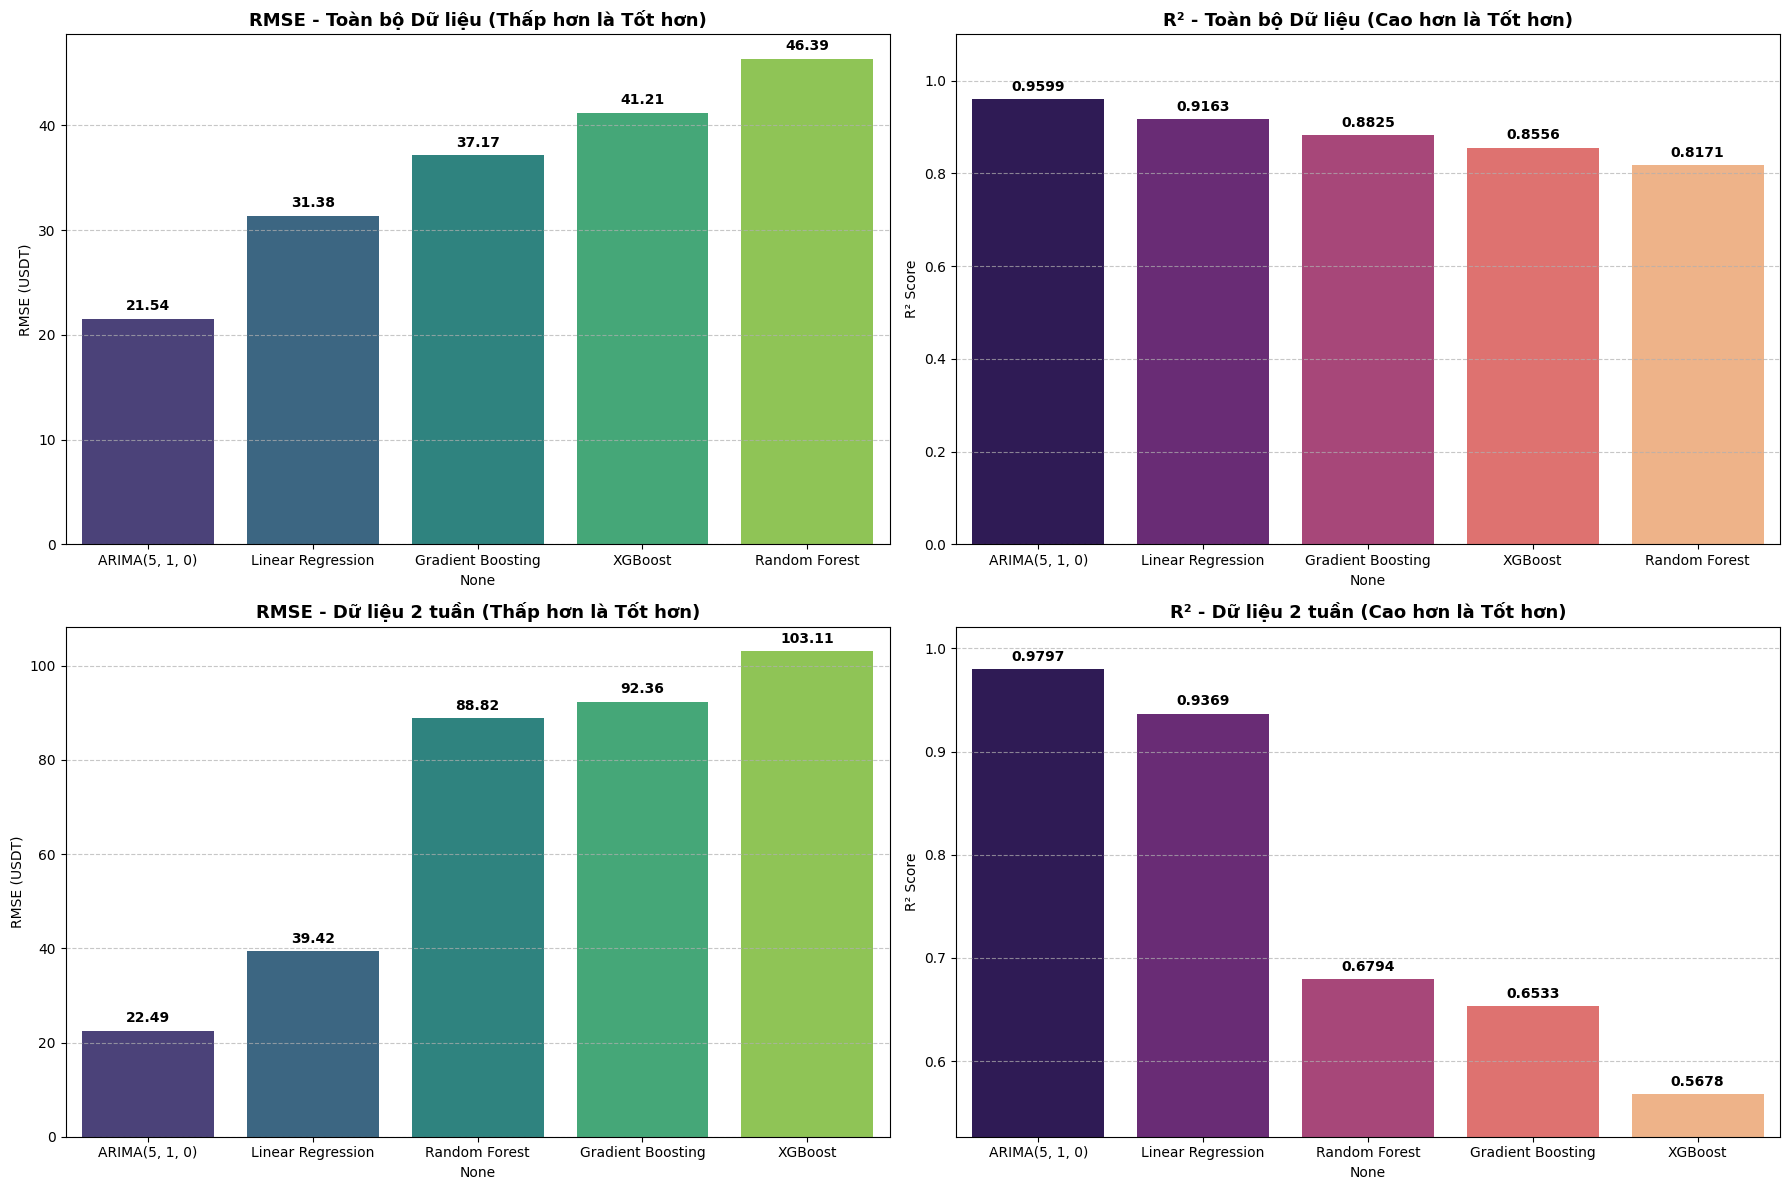

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- CHUẨN BỊ DỮ LIỆU ĐỂ VẼ ---
# Đảm bảo bạn đang dùng đúng tên biến:
# 1. results_df: Kết quả chạy FULL dữ liệu
# 2. results_subset_df: Kết quả chạy 2 TUẦN (hoặc subset bạn vừa tạo)

# Tạo khung hình 2x2
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# =============================================
# HÀNG 1: TOÀN BỘ DỮ LIỆU (Full Data)
# =============================================

# 1.1 RMSE Full
sns.barplot(x=results_full_df.index, y='RMSE', data=results_full_df, ax=axes[0, 0], palette='viridis')
axes[0, 0].set_title('RMSE - Toàn bộ Dữ liệu (Thấp hơn là Tốt hơn)', fontsize=13, fontweight='bold')
axes[0, 0].set_ylabel('RMSE (USDT)')
axes[0, 0].grid(axis='y', linestyle='--', alpha=0.7)

# Ghi số lên cột
for p in axes[0, 0].patches:
    axes[0, 0].annotate(f'{p.get_height():.2f}', 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='center', xytext=(0, 9), 
                        textcoords='offset points', fontsize=10, fontweight='bold')

# 1.2 R2 Full
sns.barplot(x=results_full_df.index, y='R2', data=results_full_df, ax=axes[0, 1], palette='magma')
axes[0, 1].set_title('R² - Toàn bộ Dữ liệu (Cao hơn là Tốt hơn)', fontsize=13, fontweight='bold')
axes[0, 1].set_ylabel('R² Score')
axes[0, 1].set_ylim(0, 1.1) # Full dữ liệu thường dương nên set 0->1.1 cho đẹp
axes[0, 1].grid(axis='y', linestyle='--', alpha=0.7)

for p in axes[0, 1].patches:
    axes[0, 1].annotate(f'{p.get_height():.4f}', 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='center', xytext=(0, 9), 
                        textcoords='offset points', fontsize=10, fontweight='bold')


# 2.1 RMSE Subset
sns.barplot(x=results_subset_df.index, y='RMSE', data=results_subset_df, ax=axes[1, 0], palette='viridis')
axes[1, 0].set_title('RMSE - Dữ liệu 2 tuần (Thấp hơn là Tốt hơn)', fontsize=13, fontweight='bold')
axes[1, 0].set_ylabel('RMSE (USDT)')
axes[1, 0].grid(axis='y', linestyle='--', alpha=0.7)

for p in axes[1, 0].patches:
    axes[1, 0].annotate(f'{p.get_height():.2f}', 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='center', xytext=(0, 9), 
                        textcoords='offset points', fontsize=10, fontweight='bold')

# 2.2 R2 Subset (Xử lý trục Y động vì có thể bị Âm)
sns.barplot(x=results_subset_df.index, y='R2', data=results_subset_df, ax=axes[1, 1], palette='magma')
axes[1, 1].set_title('R² - Dữ liệu 2 tuần (Cao hơn là Tốt hơn)', fontsize=13, fontweight='bold')
axes[1, 1].set_ylabel('R² Score')

# Tính toán giới hạn trục Y để biểu đồ không bị mất cột nếu R2 âm
min_r2 = results_subset_df['R2'].min()
max_r2 = results_subset_df['R2'].max()
padding = (max_r2 - min_r2) * 0.1 if max_r2 != min_r2 else 0.5
axes[1, 1].set_ylim(min_r2 - padding, max_r2 + padding)

# Vẽ đường kẻ ngang màu đỏ tại mức 0 để dễ nhìn tham chiếu
axes[1, 1].axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.8)
axes[1, 1].grid(axis='y', linestyle='--', alpha=0.7)

for p in axes[1, 1].patches:
    axes[1, 1].annotate(f'{p.get_height():.4f}', 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='center', xytext=(0, 9), 
                        textcoords='offset points', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

### 3.4 Bảng So sánh Chi tiết

In [11]:
# Tạo bảng so sánh chi tiết
comparison_data = []

for model_name in results_full_df.index:
    comparison_data.append({
        'Model': model_name,
        'Full_Data_RMSE': results_full_df.loc[model_name, 'RMSE'],
        'Full_Data_R2': results_full_df.loc[model_name, 'R2'],
        'Month_Data_RMSE': results_subset_df.loc[model_name, 'RMSE'],
        'Month_Data_R2': results_subset_df.loc[model_name, 'R2'],
        'RMSE_Diff': results_subset_df.loc[model_name, 'RMSE'] - results_full_df.loc[model_name, 'RMSE'],
        'R2_Diff': results_subset_df.loc[model_name, 'R2'] - results_full_df.loc[model_name, 'R2']
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.set_index('Model')

print("So sánh giữa Toàn bộ Dữ liệu vs Dữ liệu 2 Tuần:")
print("=" * 100)
display(comparison_df)

print("\n📊 Giải thích:")
print("- Full_Data: Kết quả từ toàn bộ dữ liệu")
print("- Month_Data: Kết quả từ dữ liệu 2 tuần gần nhất")
print("- Diff: Sự khác biệt (Month - Full)")
print("  + RMSE_Diff âm: Model tốt hơn trên dữ liệu 2 tuần")
print("  + R2_Diff dương: Model tốt hơn trên dữ liệu 2 tuần")

So sánh giữa Toàn bộ Dữ liệu vs Dữ liệu 2 Tuần:


,Full_Data_RMSE,Full_Data_R2,Month_Data_RMSE,Month_Data_R2,RMSE_Diff,R2_Diff
Model,,,,,,
"ARIMA(5, 1, 0)",21.536745,0.959911,22.485995,0.979715,0.949250,0.019804
Linear Regression,31.377837,0.916306,39.415777,0.936852,8.037940,0.020546
Gradient Boosting,37.172508,0.882539,92.357153,0.653292,55.184645,-0.229246
XGBoost,41.211951,0.855623,103.111932,0.567844,61.899981,-0.287779
Random Forest,46.388709,0.817074,88.818423,0.679352,42.429714,-0.137722



📊 Giải thích:
- Full_Data: Kết quả từ toàn bộ dữ liệu
- Month_Data: Kết quả từ dữ liệu 2 tuần gần nhất
- Diff: Sự khác biệt (Month - Full)
  + RMSE_Diff âm: Model tốt hơn trên dữ liệu 2 tuần
  + R2_Diff dương: Model tốt hơn trên dữ liệu 2 tuần


## 4. Nhận xét và Đánh giá Kết quả (Results Analysis)

Dựa trên bảng tổng hợp hiệu suất các mô hình trên hai bộ dữ liệu, ta có những nhận định sau:

---

### 4.1. Kết quả trên Toàn bộ Dữ liệu (976 records - ~40 ngày)

| Model | RMSE | R² Score |
|:------|:----:|:--------:|
| **ARIMA(5,1,0)** | **21.54** | **0.960** |
| Linear Regression | 31.38 | 0.916 |
| Gradient Boosting | 37.17 | 0.883 |
| XGBoost | 41.21 | 0.856 |
| Random Forest | 46.39 | 0.817 |

---

### 4.2. Kết quả trên Dữ liệu 2 Tuần (337 records - 14 ngày)

| Model | RMSE | R² Score |
|:------|:----:|:--------:|
| **ARIMA(5,1,0)** | **22.49** | **0.980** |
| Linear Regression | 39.42 | 0.937 |
| Random Forest | 88.82 | 0.679 |
| Gradient Boosting | 92.36 | 0.653 |
| XGBoost | 103.11 | 0.568 |

---

### 4.3. Phân tích nguyên nhân

**1. Tại sao ARIMA đạt hiệu suất tốt nhất?**

- ARIMA là mô hình **chuyên biệt cho time series**, được thiết kế để nắm bắt: xu hướng (trend), tự tương quan (autocorrelation), và tính dừng (stationarity).
- Với phương pháp **Rolling Forecast** (dự báo từng bước và cập nhật), ARIMA có thể **thích nghi liên tục** với thay đổi gần nhất của thị trường.
- Giá crypto có tính chất **random walk** mạnh - ARIMA với (5,1,0) mô hình hóa tốt đặc tính này.

**2. Tại sao Linear Regression vẫn tốt thứ hai?**

- Trong khung thời gian ngắn hạn (1 giờ), mối quan hệ $Price_t \approx Price_{t-1} + \epsilon$ gần như tuyến tính.
- Model đơn giản, ít tham số nên ổn định trên cả hai bộ dữ liệu.

**3. Tại sao tree-based models thất bại trên dữ liệu 2 tuần?**

- **Dữ liệu quá ít** (~270 samples train) dẫn đến **overfitting nghiêm trọng**.
- Tree-based models cần nhiều dữ liệu để học patterns. Với dataset nhỏ, chúng học "noise" thay vì "signal".
- Sự suy giảm rõ rệt: XGBoost R² giảm **-0.29**, Gradient Boosting giảm **-0.23**.

---

### 4.4. So sánh tổng hợp giữa 2 trường hợp

| Model | Full Data RMSE | 2 Tuần RMSE | RMSE Diff | Full Data R² | 2 Tuần R² | R² Diff |
|:------|:--------------:|:-----------:|:---------:|:------------:|:---------:|:-------:|
| **ARIMA(5,1,0)** | 21.54 | 22.49 | +0.95 | 0.960 | **0.980** | +0.02 |
| Linear Regression | 31.38 | 39.42 | +8.04 | 0.916 | 0.937 | +0.02 |
| Gradient Boosting | 37.17 | 92.36 | +55.18 | 0.883 | 0.653 | -0.23 |
| XGBoost | 41.21 | 103.11 | +61.90 | 0.856 | 0.568 | -0.29 |
| Random Forest | 46.39 | 88.82 | +42.43 | 0.817 | 0.679 | -0.14 |

---

### 4.5. Kết luận

- **ARIMA(5,1,0) với Rolling Forecast** là mô hình tốt nhất cho bài toán dự báo giá crypto ngắn hạn.
- **Linear Regression** là lựa chọn an toàn và ổn định nếu không muốn sử dụng time series model.
- **Không nên** sử dụng tree-based models trên dữ liệu quá nhỏ (< 500 samples).
- Để cải thiện: có thể thử **SARIMAX** (thêm yếu tố seasonality) hoặc **LSTM/GRU** cho deep learning approach.

## 5. So sánh hiệu suất dự đoán giữa 2 model tốt nhất: ARIMA và Linear Regression

Model #1: ARIMA(5, 1, 0) - RMSE: 21.54, R²: 0.9599
Model #2: Linear Regression - RMSE: 31.38, R²: 0.9163


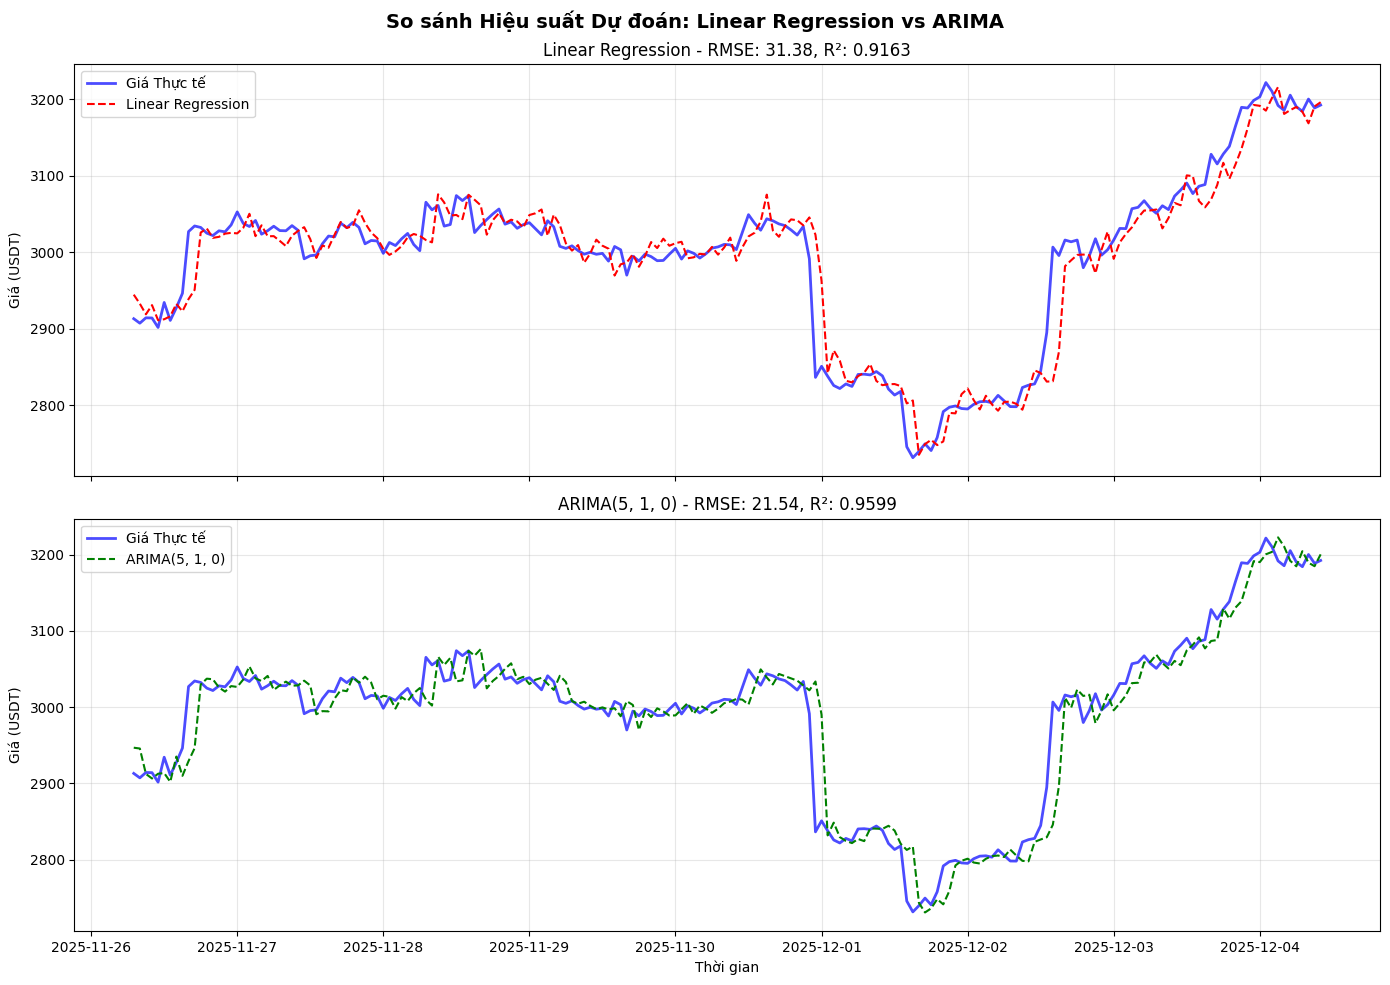

In [13]:
# So sánh hiệu suất dự đoán giữa Linear Regression và ARIMA

# Lấy 2 model tốt nhất
best_model_1 = results_full_df.index[0]  # ARIMA
best_model_2 = results_full_df.index[1]  # Linear Regression

print(f"Model #1: {best_model_1} - RMSE: {results_full_df.loc[best_model_1, 'RMSE']:.2f}, R²: {results_full_df.loc[best_model_1, 'R2']:.4f}")
print(f"Model #2: {best_model_2} - RMSE: {results_full_df.loc[best_model_2, 'RMSE']:.2f}, R²: {results_full_df.loc[best_model_2, 'R2']:.4f}")

# Lấy predictions
y_pred_1 = results_full[best_model_1]["Prediction"]
y_pred_2 = results_full[best_model_2]["Prediction"]

# Tạo DataFrame
plot_df = pd.DataFrame({
    'Actual': y_test_full.values,
    best_model_1: y_pred_1,
    best_model_2: y_pred_2
}, index=y_test_full.index)

# Vẽ biểu đồ 2 subplots
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot 1: Linear Regression
axes[0].plot(plot_df.index, plot_df['Actual'], label='Giá Thực tế', color='blue', alpha=0.7, linewidth=2)
axes[0].plot(plot_df.index, plot_df[best_model_2], label=best_model_2, color='red', linestyle='--', linewidth=1.5)
axes[0].set_title(f'{best_model_2} - RMSE: {results_full_df.loc[best_model_2, "RMSE"]:.2f}, R²: {results_full_df.loc[best_model_2, "R2"]:.4f}')
axes[0].set_ylabel('Giá (USDT)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: ARIMA
axes[1].plot(plot_df.index, plot_df['Actual'], label='Giá Thực tế', color='blue', alpha=0.7, linewidth=2)
axes[1].plot(plot_df.index, plot_df[best_model_1], label=best_model_1, color='green', linestyle='--', linewidth=1.5)
axes[1].set_title(f'{best_model_1} - RMSE: {results_full_df.loc[best_model_1, "RMSE"]:.2f}, R²: {results_full_df.loc[best_model_1, "R2"]:.4f}')
axes[1].set_xlabel('Thời gian')
axes[1].set_ylabel('Giá (USDT)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle('So sánh Hiệu suất Dự đoán: Linear Regression vs ARIMA', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Phân tích Trực quan Kết quả Dự báo (Visual Analysis)

Biểu đồ dưới đây thể hiện sự so sánh giữa **Giá Thực tế (Xanh)** và **Giá Dự đoán** bởi hai mô hình tốt nhất: **Linear Regression (Đỏ)** và **ARIMA(5,1,0) (Xanh lá)** trên tập dữ liệu kiểm thử (Test set).

---

### 5.1. So sánh hiệu suất tổng quan

| Model | RMSE (USDT) | R² Score | Sai số tương đối (~3000 USDT) |
|:------|:-----------:|:--------:|:-----------------------------:|
| **ARIMA(5,1,0)** | **21.54** | **0.9599** | ~0.72% |
| Linear Regression | 31.38 | 0.9163 | ~1.05% |

---

### 5.2. Quan sát từ biểu đồ

**1. Linear Regression (Biểu đồ trên):**
- Đường dự đoán (đỏ) bám khá sát đường giá thực tế (xanh), nắm bắt tốt xu hướng tăng/giảm chính.
- Có hiện tượng **trễ (lag)** rõ rệt: Khi giá thực tế tăng/giảm đột ngột, dự đoán phản ứng chậm hơn 1 nhịp (1 giờ).
- **Nguyên nhân:** Feature quan trọng nhất là `close_lag1` (giá giờ trước), nên mô hình có xu hướng dự đoán $P_{t+1} \approx P_t$.

**2. ARIMA(5,1,0) (Biểu đồ dưới):**
- Đường dự đoán (xanh lá) bám **sát hơn đáng kể** so với Linear Regression.
- Hiện tượng trễ **giảm thiểu** nhờ cơ chế Rolling Forecast - cập nhật mô hình liên tục với giá trị thực tế mới nhất.
- Tại các điểm biến động mạnh (như ngày 2025-12-01), ARIMA phản ứng nhanh hơn và chính xác hơn.

**3. So sánh tại các thời điểm quan trọng:**
- **Đợt giảm mạnh (2025-12-01):** ARIMA theo sát biến động xuống ~2750 USDT, trong khi Linear bị trễ đáng kể.
- **Đợt phục hồi (2025-12-02 → 2025-12-04):** Cả hai đều bám sát, nhưng ARIMA có biên độ sai số nhỏ hơn.
- **Giai đoạn sideway:** Cả hai đều hoạt động tốt với sai số thấp.

---

### 5.3. Kết luận

- **ARIMA(5,1,0)** với Rolling Forecast cho kết quả tốt hơn ~32% về RMSE so với Linear Regression (21.54 vs 31.38).
- Điểm mạnh của ARIMA: Phản ứng nhanh hơn với biến động thị trường nhờ cơ chế cập nhật liên tục.
- Điểm yếu chung: Cả hai mô hình đều có xu hướng trễ khi thị trường biến động đột ngột - đây là hạn chế cố hữu của phương pháp dự báo dựa trên dữ liệu lịch sử.

## 6. Kết luận chung

---

### 6.1. Model phù hợp nhất

**ARIMA(5,1,0) với Rolling Forecast** là lựa chọn tốt nhất cho dự báo giá ETHUSDT ngắn hạn nhờ:

- **Hiệu suất cao nhất:** RMSE = 21.54, R² = 0.96
- **Phản ứng nhanh:** Cập nhật liên tục với dữ liệu mới nhất
- **Ổn định:** Hoạt động tốt trên cả toàn bộ dữ liệu và 2 tuần gần nhất (R² thậm chí cao hơn: 0.98)

**Linear Regression** là lựa chọn thứ hai tốt nhờ:

- Sự đơn giản và ổn định
- Tốc độ huấn luyện nhanh
- Độ chính xác cao và nhất quán trên cả 2 bộ dữ liệu
- Không bị overfitting khi dữ liệu ít

---

### 6.2. Bài học về kích thước dữ liệu

| Kích thước Dataset | Models phù hợp | Lưu ý |
|:-------------------|:---------------|:------|
| **Lớn (>500 samples)** | ARIMA, Linear Regression, Tree-based models | Tree-based cần nhiều data để học patterns |
| **Nhỏ (<300 samples)** | ARIMA, Linear Regression | Không nên dùng Random Forest, XGBoost, Gradient Boosting |

Dữ liệu 2 tuần cho thấy **rủi ro nghiêm trọng** khi dùng models phức tạp trên data nhỏ: R² giảm từ 0.85 → 0.57 (XGBoost).

---

### 6.3. Hướng phát triển

Để nâng cao độ chính xác và giảm "độ trễ" (lag), cần xem xét:

1. **Features nâng cao:** RSI, MACD, Bollinger Bands, Volume indicators
2. **External data:** Sentiment analysis, News events, Market correlation
3. **Deep Learning:** LSTM/GRU cho time-series, Transformer-based models
4. **Ensemble methods:** Kết hợp ARIMA với ML models (Hybrid approach)
5. **Auto-ARIMA:** Tự động tìm tham số (p, d, q) tối ưu cho từng giai đoạn thị trường